# 3.0 - Feature Selection and Initial EDA

_by Michael Joshua Vargas_

This notebook performs feature selection based on Information Value (IV) and correlation analysis, and then conducts initial exploratory data analysis (EDA) on the selected features.


In [1]:
%load_ext autoreload
%autoreload
%reload_ext autoreload

### Import relevant libraries


In [2]:
import pandas as pd
import numpy as np
import ast

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from scipy import stats
from scipy.stats import chi2_contingency
from matplotlib.colors import LinearSegmentedColormap

import os

import sys
from pathlib import Path

import warnings

warnings.filterwarnings('ignore')

### Load the dataset


Navigate up one level to reach the project root directory


In [3]:
# Get the current working directory of the notebook
notebook_dir = Path(os.getcwd())

# Navigate up one level to reach the project root directory
project_root = notebook_dir.parent

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Import from config.py
from bank_fraud.config import REFERENCES_DIR, DATA_DICTIONARIES_DIR, REPORTS_FIGURES_DIR

# Import the pre-parsed binning definitions
from bank_fraud.utils.numerical_binning_definitions import BINNING_DEFINITIONS

# Force reload the module to ensure latest BINNING_DEFINITIONS is used
import importlib
importlib.reload(sys.modules['bank_fraud.utils.numerical_binning_definitions'])

# Load the prepared data from the previous step
PREPARED_DATA_PATH = project_root / 'data' / 'interim' / '2.0_prepared_for_feature_selection.parquet'
df = pd.read_parquet(PREPARED_DATA_PATH).copy()

Load the prepared data from the previous step


## Initial EDA


### **Target Variable Analysis (`dna_final_tag`)**

Analyzing the distribution of our target variable, `dna_final_tag`, is a foundational step in any classification problem, and particularly critical in fraud detection.

   * **Understanding Class Imbalance**: Fraud datasets are inherently imbalanced (fraudulent     
     cases are rare). This analysis quantifies the proportion of `CONFIRMED_FRAUD` versus      
     `NON_FRAUD` accounts in our filtered dataset.
     
   * **Informing Model Strategy**: The degree of imbalance directly impacts our choice of machine
      learning models, evaluation metrics (e.g., precision, recall, F1-score over accuracy), 
     and potential sampling techniques (e.g., oversampling, undersampling) needed to build a 
     robust and fair fraud detection system.

This analysis provides essential insights into the nature of the problem we are trying to solve and guides our subsequent modeling decisions.


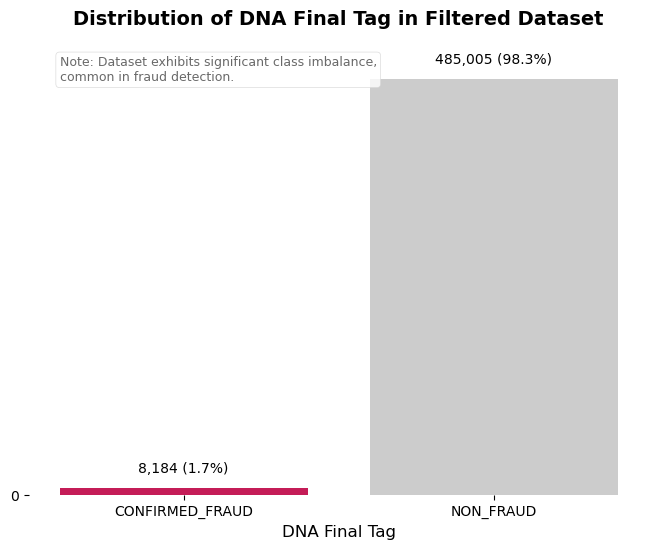

Plot saved to: reports\figures\3.0_dna_final_tag_distribution.png


In [4]:
# Define the custom color palette (for reference)
CUSTOM_PALETTE_RAW = ["#ffdd00", "#e0004e", "#01f0fb", "#4a0be8", "#ffffff", "#021820"]

# Define highlight and muted colors for the target variable
HIGHLIGHT_FRAUD_COLOR = "#e0004e" # Reddish for CONFIRMED_FRAUD
MUTED_NON_FRAUD_COLOR = "#cccccc" # Gray for NON_FRAUD

# Calculate the frequency and percentage of each category in the target variable
target_distribution = df['dna_final_tag'].value_counts()
target_percentage = (df['dna_final_tag'].value_counts(normalize=True) * 100)

# Ensure consistent order for plotting and color assignment
plot_order = ['CONFIRMED_FRAUD', 'NON_FRAUD']
target_distribution = target_distribution.reindex(plot_order, fill_value=0)
target_percentage = target_percentage.reindex(plot_order, fill_value=0)


# Determine the colors for the bars based on the category
bar_colors = [HIGHLIGHT_FRAUD_COLOR if tag == 'CONFIRMED_FRAUD' else MUTED_NON_FRAUD_COLOR
              for tag in target_distribution.index]

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=target_distribution.index, y=target_distribution.values, palette=bar_colors)

# Add data labels (counts and percentages)
# Calculate a dynamic offset based on the maximum bar height to ensure text is outside
max_bar_height = target_distribution.max()
y_label_padding = max_bar_height * 0.03 # 3% of max bar height as padding

for i, p in enumerate(ax.patches):
    height = p.get_height()
    current_percentage = target_percentage.iloc[i]

    # Determine text color based on bar color for contrast
    if mcolors.to_rgb(bar_colors[i]) == mcolors.to_rgb(HIGHLIGHT_FRAUD_COLOR):
        text_color = 'black'
    else:
        text_color = 'black'

    # Position text above the bar
    ax.text(p.get_x() + p.get_width() / 2.,
            height + y_label_padding, # Position text above the bar with padding
            f'{int(height):,} ({current_percentage:.1f}%)',
            ha='center', va='bottom', fontsize=10, color=text_color)

# Remove chart junk (top, right, left, and bottom spines)
sns.despine(left=True, bottom=True) # Remove all spines for a cleaner look

# Set y-axis to show only '0'
ax.set_yticks([0]) # Set only one tick at 0
ax.set_yticklabels(['0']) # Label that tick as '0'
ax.set_ylabel('') # Remove y-axis label text

# Adjust y-axis limits to ensure labels are visible
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin, ymax + y_label_padding * 2) # Extend y-axis by padding for labels

# Add annotation for class imbalance
# Position it strategically, e.g., top-left or top-right, away from bars
ax.text(0.05, 0.95, # x, y coordinates in axes fraction
        'Note: Dataset exhibits significant class imbalance,\ncommon in fraud detection.',
        transform=ax.transAxes, # Coordinates are relative to axes
        horizontalalignment='left',
        verticalalignment='top',
        fontsize=9, color='dimgray',
        bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='lightgray', lw=0.5, alpha=0.8))


plt.title('Distribution of DNA Final Tag in Filtered Dataset', fontsize=14, fontweight='bold')
plt.xlabel('DNA Final Tag', fontsize=12)
plt.show()

output_filename = REPORTS_FIGURES_DIR / '3.0_dna_final_tag_distribution.png'
plt.savefig(output_filename, bbox_inches='tight')
print(f"Plot saved to: {output_filename.relative_to(project_root)}")
plt.close()

### IV Calculation


#### Categorical Features


Information Value (IV) is a crucial metric in feature selection for credit scoring and fraud detection models. It quantifies the predictive power of a variable by measuring how well it separates the "good" (non-fraudulent) and "bad" (fraudulent) cases.

**Interpretation of IV:**
- **< 0.02:** INSIGNIFICANT - Not Useful for prediction
- **0.02 to 0.1:** Weak predictor
- **0.1 to 0.3:** Medium predictor
- **0.3 to 0.5:** Strong predictor
- **> 0.5:** Suspiciously Strong (might be too good to be true, check for data leakage)

**Formulas for Calculation:**
For each category within a feature:
- **%Good (Percentage of Good Customers):** (Number of Good Customers in Category / Total Good Customers)
- **%Bad (Percentage of Bad Customers):** (Number of Bad Customers in Category / Total Bad Customers)
- **WoE (Weight of Evidence):** ln(%Good / %Bad)
- If %Good or %Bad is 0, WoE is set to 0 to handle infinite values.
- **IV (Information Value):** (%Good - %Bad) * WoE

The total IV for a feature is the sum of the IVs for all its categories.


This section calculates the IV for all categorical features in the dataset, helping us identify the most relevant features for our fraud detection model.

Information Value (IV) is a crucial metric in feature selection for credit scoring and fraud detection models. It quantifies the predictive power of a variable by measuring how well it separates the "good" (non-fraudulent) and "bad" (fraudulent) cases.

**Interpretation of IV:**
- **< 0.02:** INSIGNIFICANT - Not Useful for prediction
- **0.02 to 0.1:** Weak predictor
- **0.1 to 0.3:** Medium predictor
- **0.3 to 0.5:** Strong predictor
- **> 0.5:** Suspiciously Strong (might be too good to be true, check for data leakage)

**Formulas for Calculation:**
For each category within a feature:
- **%Good (Percentage of Good Customers):** (Number of Good Customers in Category / Total Good Customers)
- **%Bad (Percentage of Bad Customers):** (Number of Bad Customers in Category / Total Bad Customers)
- **WoE (Weight of Evidence):** ln(%Good / %Bad)
- If %Good or %Bad is 0, WoE is set to 0 to handle infinite values.
- **IV (Information Value):** (%Good - %Bad) * WoE

The total IV for a feature is the sum of the IVs for all its categories.


This section calculates the IV for all categorical features in the dataset, helping us identify the most relevant features for our fraud detection model.


In [10]:
def calculate_iv_user_formula(df: pd.DataFrame, feature_cols: list[str], target_col: str) -> tuple[pd.DataFrame, dict[str, pd.DataFrame]]:
    """
    Calculates WoE and IV using a specific formula to handle zero counts.
    WoE = 0 if % Good or % Bad is 0, otherwise LN(% Good / % Bad).

    Args:
        df: The input DataFrame.
        feature_cols: A list of categorical column names to calculate IV for.
        target_col: The name of the binary target column (must contain 0s and 1s).

    Returns:
        A tuple containing:
        - iv_summary: A pandas DataFrame summarizing the IV for each feature.
        - iv_details: A dictionary where keys are feature names and values are DataFrames
                      with detailed WoE and IV calculations for each category.
    """
    iv_summary_list = []
    iv_details_dict = {}
    all_iv_details_dfs = [] # To store formatted IV details for all features

    # Ensure target is binary 0/1
    if not all(df[target_col].isin([0, 1])):
        raise ValueError("Target column must contain only 0s and 1s.")

    total_good = len(df[df[target_col] == 0])
    total_bad = len(df[df[target_col] == 1])

    if total_good == 0 or total_bad == 0:
        print("Warning: The target variable contains only one class. IV cannot be calculated.")
        return pd.DataFrame(), {}

    for feature in feature_cols:
        # Create a contingency table
        contingency_table = pd.crosstab(df[feature], df[target_col])
        
        # Ensure both 'Good' (0) and 'Bad' (1) columns exist
        if 0 not in contingency_table.columns:
            contingency_table[0] = 0
        if 1 not in contingency_table.columns:
            contingency_table[1] = 0
            
        contingency_table = contingency_table.rename(columns={0: 'NON_FRAUD', 1: 'CONFIRMED_FRAUD'})

        # Explicitly copy the DataFrame here to ensure subsequent operations are on a fresh object
        contingency_table_processed = contingency_table.copy()

        # Calculate percentages
        contingency_table_processed['PercentGood'] = contingency_table_processed['NON_FRAUD'] / total_good
        contingency_table_processed['PercentBad'] = contingency_table_processed['CONFIRMED_FRAUD'] / total_bad

        # Calculate WoE using your specific formula
        contingency_table_processed['WoE'] = np.where(
            (contingency_table_processed['PercentGood'] == 0) | (contingency_table_processed['PercentBad'] == 0),
            0,
            np.log(contingency_table_processed['PercentGood'] / contingency_table_processed['PercentBad'])
        )

        # Calculate IV
        contingency_table_processed['IV'] = (contingency_table_processed['PercentGood'] - contingency_table_processed['PercentBad']) * contingency_table_processed['WoE']

        total_iv = contingency_table_processed['IV'].sum()

        # Store results
        iv_summary_list.append({'Feature': feature, 'IV': total_iv})
        iv_details_dict[feature] = contingency_table_processed.copy() # Store a copy here too

        # --- Start of new code for detailed IV output ---
        # Calculate total count for each category
        contingency_table_processed['Total'] = contingency_table_processed['NON_FRAUD'] + contingency_table_processed['CONFIRMED_FRAUD']

        # Calculate %Share
        contingency_table_processed['%Share'] = contingency_table_processed['Total'] / len(df)

        # Now, contingency_table_processed has all the necessary columns with correct names.
        formatted_feature_df = pd.DataFrame({
            'CONFIRMED_FRAUD': contingency_table_processed['CONFIRMED_FRAUD'],
            'NON_FRAUD': contingency_table_processed['NON_FRAUD'],
            'Grand Total': contingency_table_processed['Total'],
            'Share': contingency_table_processed['%Share'],
            'PercentBad': contingency_table_processed['PercentBad'],
            'PercentGood': contingency_table_processed['PercentGood'],
            'WoE': contingency_table_processed['WoE'],
            'IV': contingency_table_processed['IV']
        }, index=contingency_table_processed.index)
        formatted_feature_df.index.name = 'Category'
        formatted_feature_df = formatted_feature_df.reset_index()
        formatted_feature_df.insert(0, 'Feature', feature)

        # Add Grand Total row for the current feature
        grand_total_row = {
            'Feature': feature,
            'Category': 'Grand Total',
            'NON_FRAUD': formatted_feature_df['NON_FRAUD'].sum(),
            'CONFIRMED_FRAUD': formatted_feature_df['CONFIRMED_FRAUD'].sum(),
            'Grand Total': formatted_feature_df['Grand Total'].sum(),
            'Share': formatted_feature_df['Share'].sum(),
            'PercentGood': 1,
            'PercentBad': 1,
            'WoE': 0, # WoE for Grand Total is typically 0
            'IV': total_iv # Total IV for the feature
        }
        formatted_feature_df = pd.concat([formatted_feature_df, pd.DataFrame([grand_total_row])], ignore_index=True)

        all_iv_details_dfs.append(formatted_feature_df)
        # --- End of new code for detailed IV output ---

    # Create summary DataFrame
    iv_summary = pd.DataFrame(iv_summary_list).sort_values(by='IV', ascending=False).reset_index(drop=True)

    def get_predictive_power(iv):
        if iv < 0.02: return 'INSIGNIFICANT - Not Useful'
        elif iv < 0.1: return 'Weak'
        elif iv < 0.3: return 'Medium'
        elif iv < 0.5: return 'Strong'
        else: return 'Suspicious - Too good to be true'

    iv_summary['Predictive Power'] = iv_summary['IV'].apply(get_predictive_power)
    iv_summary['IV'] = iv_summary['IV'].round(2) # Round IV in summary table

    # --- Save detailed IV results to individual CSVs ---
    if all_iv_details_dfs:
        iv_details_output_dir = REFERENCES_DIR / 'iv_details'
        iv_details_output_dir.mkdir(parents=True, exist_ok=True) # Ensure directory exists

        for formatted_feature_df in all_iv_details_dfs:
            formatted_feature_df['IV'] = formatted_feature_df['IV'].round(2) # Round IV in detailed table
            formatted_feature_df['WoE'] = formatted_feature_df['WoE'].round(2) # Round WoE in detailed table
            formatted_feature_df['Share'] = formatted_feature_df['Share'].round(4) # Round Share to 4 decimals
            formatted_feature_df['PercentBad'] = formatted_feature_df['PercentBad'].round(4) # Round PercentBad to 4 decimals
            formatted_feature_df['PercentGood'] = formatted_feature_df['PercentGood'].round(4) # Round PercentGood to 4 decimals

            feature_name = formatted_feature_df.loc[0, 'Feature'] # Get the feature name
            output_filename = iv_details_output_dir / f"{feature_name}_iv_details.csv"
            
            # Remove 'Feature' column before writing to CSV
            df_to_write = formatted_feature_df.drop(columns=['Feature'])
            df_to_write.to_csv(output_filename, index=False)
            print(f"Detailed IV results for '{feature_name}' saved to: {output_filename.relative_to(project_root)}")
    # --- End save detailed IV results to individual CSVs ---

    return iv_summary, iv_details_dict

In [11]:
# Convert target variable to binary
df['fraud_status'] = df['dna_final_tag'].apply(lambda x: 1 if x == 'CONFIRMED_FRAUD' else 0)

# Select categorical features for IV calculation
categorical_features = ['orig_channel', 'orig_os', 'origination_type', 'origination_sub_type', 'carded_status', 'card_type', 'orig_primary_source_of_funds', 'orig_industry', 'orig_occupation', 'athena_fraud_tag', 'acc_mgmt_channel', 'first_kiosk_interaction_organisation_site_name', 'first_kiosk_interaction_organisation_presence_category', 'first_kiosk_interaction_organisation_name', 'first_kiosk_interaction_kiosk_interaction_type', 'latest_kiosk_interaction_organisation_site_name', 'latest_kiosk_interaction_organisation_presence_category', 'latest_kiosk_interaction_organisation_name', 'latest_kiosk_interaction_kiosk_interaction_type', 'first_fila_bank_code', 'final_tag', 'dna_final_tag', 'fraud_types', 'fraud_channel_source', 'matching_level', 'change_email_flag', 'change_mob_num_flag', 'flag_txn_dropoff_after_wk1']

# Calculate IV
iv_summary, iv_details = calculate_iv_user_formula(df, categorical_features, 'fraud_status')

# Display IV summary
print("--- Information Value (IV) Summary ---")
display(iv_summary)

Detailed IV results for 'orig_channel' saved to: references\iv_details\orig_channel_iv_details.csv
Detailed IV results for 'orig_os' saved to: references\iv_details\orig_os_iv_details.csv
Detailed IV results for 'origination_type' saved to: references\iv_details\origination_type_iv_details.csv
Detailed IV results for 'origination_sub_type' saved to: references\iv_details\origination_sub_type_iv_details.csv
Detailed IV results for 'carded_status' saved to: references\iv_details\carded_status_iv_details.csv
Detailed IV results for 'card_type' saved to: references\iv_details\card_type_iv_details.csv
Detailed IV results for 'orig_primary_source_of_funds' saved to: references\iv_details\orig_primary_source_of_funds_iv_details.csv
Detailed IV results for 'orig_industry' saved to: references\iv_details\orig_industry_iv_details.csv
Detailed IV results for 'orig_occupation' saved to: references\iv_details\orig_occupation_iv_details.csv
Detailed IV results for 'athena_fraud_tag' saved to: refere

,Feature,IV,Predictive Power
0,final_tag,13.71,Suspicious - Too good to be true
1,first_kiosk_interaction_organisation_site_name,1.30,Suspicious - Too good to be true
2,latest_kiosk_interaction_organisation_site_name,1.30,Suspicious - Too good to be true
3,first_kiosk_interaction_organisation_name,1.26,Suspicious - Too good to be true
4,latest_kiosk_interaction_organisation_name,1.26,Suspicious - Too good to be true
5,athena_fraud_tag,1.22,Suspicious - Too good to be true
6,latest_kiosk_interaction_organisation_presence...,1.15,Suspicious - Too good to be true
7,first_kiosk_interaction_organisation_presence_...,1.15,Suspicious - Too good to be true
8,first_kiosk_interaction_kiosk_interaction_type,1.12,Suspicious - Too good to be true
9,latest_kiosk_interaction_kiosk_interaction_type,1.11,Suspicious - Too good to be true


#### Sample Calculation Table


In [12]:
# View the Categorical IV details from a sample CSV
# Assuming 'orig_channel' is a representative categorical feature for demonstration
sample_feature_name = 'orig_channel' # Or pick one from categorical_features list

# Construct the path to the sample feature's IV details CSV
sample_output_path = REFERENCES_DIR / 'iv_details' / f'{sample_feature_name}_iv_details.csv'

# Check if the file exists before attempting to read
if sample_output_path.exists():
    iv_cat = pd.read_csv(sample_output_path)
    print(f"Sample IV details for '{sample_feature_name}' from: {sample_output_path.relative_to(project_root)}")
    display(iv_cat.head())
else:
    print(f"Sample IV details file not found for '{sample_feature_name}' at: {sample_output_path.relative_to(project_root)}")
    print("Please ensure the IV calculation has been run and the file generated.")

Sample IV details for 'orig_channel' from: references\iv_details\orig_channel_iv_details.csv


,Category,CONFIRMED_FRAUD,NON_FRAUD,Grand Total,Share,PercentBad,PercentGood,WoE,IV
0,Digital mobile channel,7354,224384,231738,0.4699,0.8986,0.4626,-0.66,0.29
1,Enterprise channel,97,12763,12860,0.0261,0.0119,0.0263,0.80,0.01
2,Physical retail channel,733,247858,248591,0.5040,0.0896,0.5110,1.74,0.73
3,Grand Total,8184,485005,493189,1.0000,1.0000,1.0000,0.00,1.03


#### Numerical Features


Similar to categorical features, numerical features also require transformation to calculate Information Value (IV). This process, known as **binning**, groups continuous numerical values into discrete intervals or "bins." This is essential because IV is fundamentally designed for categorical variables, measuring the predictive power of each category in separating target classes (e.g., fraud vs. non-fraud).

**Our Approach to Numerical Binning and IV Calculation:**

1.  **Pre-processed Binning Rules:** To ensure consistency, optimize performance, and address specific domain-driven requirements, the binning rules for numerical features are pre-defined and pre-processed. These rules are stored in `numerical_binning_rules.csv` and then parsed and saved as a Python module (`bank_fraud/utils/numerical_binning_definitions.py`) by the `numerical_binning_script.py`. This pre-processing step ensures that complex binning logic (e.g., handling shorthand values like '1K', '5M', or specific ranges) is handled efficiently.
2.  **Dynamic Binning Application:** During the IV calculation, these pre-processed definitions are loaded. Each numerical feature is then dynamically binned according to its specific rules.
3.  **IV and WoE Computation:** Once binned, the numerical features are treated as categorical. The `iv_calculation.py` script (or similar logic within this notebook) then computes the Weight of Evidence (WoE) for each bin and the overall Information Value (IV) for the feature, following the same principles as for categorical variables.

This structured approach to numerical binning allows us to effectively assess the predictive strength of continuous variables in our fraud detection model, providing insights into which value ranges are most indicative of fraudulent behavior.


In [13]:
def parse_bin_edge(edge_str: str) -> float:
    """Converts a string edge (e.g., '1K', '5M') to a float."""
    edge_str = str(edge_str).strip().upper()
    if 'M' in edge_str:
        return float(edge_str.replace('M', '')) * 1_000_000
    if 'K' in edge_str:
        return float(edge_str.replace('K', '')) * 1_000
    return float(edge_str)

def format_label_value(value: float) -> str:
    """Formats a numeric value into a human-readable string with K/M shorthand."""
    if value >= 1_000_000:
        return f"{value / 1_000_000:.0f}M"
    if value >= 1_000:
        return f"{value / 1_000:.0f}K"
    return str(int(value))

def create_custom_labels(bin_edges: list) -> list[str]:
    """Creates human-readable labels like '0 - <1K' from a list of bin edges."""
    labels = []
    # Add label for the interval below the first edge
    labels.append(f"< {format_label_value(bin_edges[0])}")
    
    # Create labels for intervals between edges
    for i in range(len(bin_edges) - 1):
        lower = format_label_value(bin_edges[i])
        upper = format_label_value(bin_edges[i+1])
        labels.append(f"{lower} - <{upper}")
        
    import pandas as pd
import numpy as np
from pathlib import Path

# Import the pre-parsed binning definitions
from bank_fraud.utils.numerical_binning_definitions import BINNING_DEFINITIONS

# Force reload the module to ensure latest BINNING_DEFINITIONS is used
import importlib
importlib.reload(sys.modules['bank_fraud.utils.numerical_binning_definitions'])

def calculate_numerical_iv(df: pd.DataFrame, target_col: str) -> tuple[pd.DataFrame, dict]:
    """
    Calculates WoE and IV for numerical features based on custom binning rules
    and saves the detailed output to a CSV file.
    """
    iv_summary_list = []
    iv_details_dict = {}
    all_iv_details_dfs = [] # To store formatted IV details for CSV export

    total_good = len(df[df[target_col] == 0])
    total_bad = len(df[df[target_col] == 1])

    if total_good == 0 or total_bad == 0:
        print("Warning: Target variable has only one class. IV cannot be calculated.")
        return pd.DataFrame(), {}

    def map_value_to_bin(value, parsed_rules: list):
        for rule in parsed_rules:
            rule_type = rule['type']
            rule_label = rule['label']

            if rule_type == 'text':
                if rule_label.lower() == 'negative accel (<0)' and value < 0:
                    return rule_label
                if rule_label.lower() == 'positive accel (>0)' and value > 0:
                    return rule_label
            elif rule_type == 'exact':
                if value == rule['value']:
                    return rule_label
            elif rule_type == 'range_le_lt': # [low, high)
                if rule['low'] <= value < rule['high']:
                    return rule_label
            elif rule_type == 'range_ge': # [low, inf)
                if value >= rule['low']:
                    return rule_label
            elif rule_type == 'range_lt': # (-inf, high)
                if value < rule['high']:
                    return rule_label
            elif rule_type == 'range_gt': # (low, inf)
                if value > rule['low']:
                    return rule_label
        return 'Other' # Fallback category

    # --- Main Loop ---
    print(f"\nTotal features in BINNING_DEFINITIONS: {len(BINNING_DEFINITIONS)}")
    processed_features_count = 0
    skipped_features = []

    for feature, parsed_bin_rules in BINNING_DEFINITIONS.items():
        if feature not in df.columns:
            skipped_features.append(feature)
            continue
        processed_features_count += 1

        binned_col_name = f"{feature}_binned"
        
        # Apply the robust mapping function using pre-parsed rules
        df[binned_col_name] = df[feature].apply(lambda x: map_value_to_bin(x, parsed_bin_rules))
        
        # --- IV Calculation ---
        contingency_table = pd.crosstab(df[binned_col_name], df[target_col])
        contingency_table = contingency_table.rename(columns={0: 'NON_FRAUD', 1: 'CONFIRMED_FRAUD'})
        
        epsilon = 1e-6
        contingency_table['PercentGood'] = (contingency_table['NON_FRAUD'] / total_good).replace(0, epsilon)
        contingency_table['PercentBad'] = (contingency_table['CONFIRMED_FRAUD'] / total_bad).replace(0, epsilon)

        contingency_table['WoE'] = np.log(contingency_table['PercentGood'] / contingency_table['PercentBad'])
        contingency_table['IV'] = (contingency_table['PercentGood'] - contingency_table['PercentBad']) * contingency_table['WoE']
        
        total_iv = contingency_table['IV'].sum()
        iv_summary_list.append({'Feature': feature, 'IV': total_iv})
        iv_details_dict[feature] = contingency_table.copy()

        # --- CSV Export Formatting ---
        # (This part remains the same as it operates on the correctly binned data)
        contingency_table['Grand Total'] = contingency_table['NON_FRAUD'] + contingency_table['CONFIRMED_FRAUD']
        contingency_table['Share'] = contingency_table['Grand Total'] / len(df)
        
        formatted_feature_df = pd.DataFrame({
            'CONFIRMED_FRAUD': contingency_table['CONFIRMED_FRAUD'],
            'NON_FRAUD': contingency_table['NON_FRAUD'],
            'Grand Total': contingency_table['Grand Total'],
            'Share': contingency_table['Share'],
            'PercentBad': contingency_table['PercentBad'],
            'PercentGood': contingency_table['PercentGood'],
            'WoE': contingency_table['WoE'],
            'IV': contingency_table['IV']
        }, index=contingency_table.index)
        formatted_feature_df.index.name = 'Category'
        formatted_feature_df = formatted_feature_df.reset_index()
        formatted_feature_df.insert(0, 'Feature', feature)

        grand_total_row = {
            'Feature': feature,
            'Category': 'Grand Total',
            'NON_FRAUD': formatted_feature_df['NON_FRAUD'].sum(),
            'CONFIRMED_FRAUD': formatted_feature_df['CONFIRMED_FRAUD'].sum(),
            'Grand Total': formatted_feature_df['Grand Total'].sum(),
            'Share': formatted_feature_df['Share'].sum(),
            'PercentGood': 1,
            'PercentBad': 1,
            'WoE': 0,
            'IV': total_iv
        }

        formatted_feature_df = pd.concat([formatted_feature_df, pd.DataFrame([grand_total_row])], ignore_index=True)
        all_iv_details_dfs.append(formatted_feature_df)

    print(f"\nTotal features processed: {processed_features_count}")
    if skipped_features:
        print(f"Features skipped (not in DataFrame): {', '.join(skipped_features)}")

    iv_summary = pd.DataFrame(iv_summary_list).sort_values(by='IV', ascending=False).reset_index(drop=True)
    
    def get_predictive_power(iv):
        if iv < 0.02: return 'INSIGNIFICANT - Not Useful'
        elif iv < 0.1: return 'Weak'
        elif iv < 0.3: return 'Medium'
        elif iv < 0.5: return 'Strong'
        else: return 'Suspicious - Too good to be true'
    
    iv_summary['Predictive Power'] = iv_summary['IV'].apply(get_predictive_power)
    iv_summary['IV'] = iv_summary['IV'].round(2) # Round IV in summary table

    # --- Save detailed IV results to individual CSVs ---
    if all_iv_details_dfs:
        iv_details_output_dir = REFERENCES_DIR / 'iv_details'
        iv_details_output_dir.mkdir(parents=True, exist_ok=True) # Ensure directory exists

        for formatted_feature_df in all_iv_details_dfs:
            formatted_feature_df['IV'] = formatted_feature_df['IV'].round(2) # Round IV in detailed table
            formatted_feature_df['WoE'] = formatted_feature_df['WoE'].round(2) # Round WoE in detailed table
            formatted_feature_df['Share'] = formatted_feature_df['Share'].round(4) # Round Share to 4 decimals
            formatted_feature_df['PercentBad'] = formatted_feature_df['PercentBad'].round(4) # Round PercentBad to 4 decimals
            formatted_feature_df['PercentGood'] = formatted_feature_df['PercentGood'].round(4) # Round PercentGood to 4 decimals

            feature_name = formatted_feature_df.loc[0, 'Feature'] # Get the feature name
            output_filename = iv_details_output_dir / f"{feature_name}_iv_details.csv"
            
            # Remove 'Feature' column before writing to CSV
            df_to_write = formatted_feature_df.drop(columns=['Feature'])
            df_to_write.to_csv(output_filename, index=False)
            print(f"Detailed IV results for '{feature_name}' saved to: {output_filename.relative_to(project_root)}")
    # --- End save detailed IV results to individual CSVs ---

    return iv_summary, iv_details_dict

In [14]:
# Calculate IV for numerical features
numerical_iv_summary, numerical_iv_details = calculate_numerical_iv(df, 'fraud_status')

# Display the summary table
print("IV Summary for Numerical Features:")
display(numerical_iv_summary)


Total features in BINNING_DEFINITIONS: 95

Total features processed: 95
Detailed IV results for 'count_PESONET_OUT' saved to: references\iv_details\count_PESONET_OUT_iv_details.csv
Detailed IV results for 'count_PESONET_IN' saved to: references\iv_details\count_PESONET_IN_iv_details.csv
Detailed IV results for 'max_amount_PESONET_OUT' saved to: references\iv_details\max_amount_PESONET_OUT_iv_details.csv
Detailed IV results for 'min_amount_PESONET_OUT' saved to: references\iv_details\min_amount_PESONET_OUT_iv_details.csv
Detailed IV results for 'rank' saved to: references\iv_details\rank_iv_details.csv
Detailed IV results for 'txn_days_active_week_wk1' saved to: references\iv_details\txn_days_active_week_wk1_iv_details.csv
Detailed IV results for 'txn_days_active_week_wk2' saved to: references\iv_details\txn_days_active_week_wk2_iv_details.csv
Detailed IV results for 'txn_days_active_week_wk3' saved to: references\iv_details\txn_days_active_week_wk3_iv_details.csv
Detailed IV results f

,Feature,IV,Predictive Power
0,max_txn_sessions_per_day_3min,2.33,Suspicious - Too good to be true
1,max_txn_sessions_per_day_5min,2.26,Suspicious - Too good to be true
2,txn_count_30d,2.25,Suspicious - Too good to be true
3,count_INSTAPAY_OUT,2.23,Suspicious - Too good to be true
4,max_txn_count_day,2.22,Suspicious - Too good to be true
...,...,...,...
90,txn_amt_vol_score_wk1,0.00,INSIGNIFICANT - Not Useful
91,count_PESONET_IN,0.00,INSIGNIFICANT - Not Useful
92,min_amount_PESONET_OUT,0.00,INSIGNIFICANT - Not Useful
93,max_amount_PESONET_OUT,0.00,INSIGNIFICANT - Not Useful


#### Sample Calculation Table


In [15]:
# View the Numerical IV details from a sample CSV
# Assuming 'total_amount_INSTAPAY_IN' is a representative numerical feature for demonstration
sample_numerical_feature_name = 'total_amount_INSTAPAY_IN' # Or pick one from numerical_features list

# Construct the path to the sample numerical feature's IV details CSV
sample_output_path_num = REFERENCES_DIR / 'iv_details' / f'{sample_numerical_feature_name}_iv_details.csv'

# Check if the file exists before attempting to read
if sample_output_path_num.exists():
    iv_num = pd.read_csv(sample_output_path_num)
    print(f"Sample IV details for '{sample_numerical_feature_name}' from: {sample_output_path_num.relative_to(project_root)}")
    display(iv_num.head())
else:
    print(f"Sample IV details file not found for '{sample_numerical_feature_name}' at: {sample_output_path_num.relative_to(project_root)}")
    print("Please ensure the IV calculation has been run and the file generated.")

Sample IV details file not found for 'total_amount_INSTAPAY_IN' at: references\iv_details\total_amount_INSTAPAY_IN_iv_details.csv
Please ensure the IV calculation has been run and the file generated.


#### Feature Selection: Dropping Low IV Features


Based on the Information Value (IV) analysis conducted for both categorical and numerical features, we identify features that have very low predictive power (IV < 0.02, classified as "INSIGNIFICANT - Not Useful"). These features contribute little to distinguishing between fraudulent and non-fraudulent accounts and can introduce noise into the model.

Removing these low IV features helps to:
*   Reduce dimensionality, leading to a simpler and more interpretable model.
*   Improve model performance by eliminating irrelevant or redundant variables.
*   Decrease training time and computational resources.

The following features will be dropped from the dataset due to their low Information Value:

| Feature Name | IV | Reason |
| :--------------------------- | :--- | :----- |
| `full_name` | N/A | INSIGNIFICANT |
| `username` | N/A | INSIGNIFICANT |
| `gr_card_no` | N/A | INSIGNIFICANT |
| `cellphone` | N/A | INSIGNIFICANT |
| `source_account_number` | N/A | INSIGNIFICANT |
| `destination_account_number` | N/A | INSIGNIFICANT |
| `carded_status` | 1.11 | Similar to card_type |
| `orig_channel` | 1.03 | Similar to acc_mgmt_channel |
| `origination_sub_type` | 1.04 | Similar to acc_mgmt_channel |
| `age_of_person` | N/A | INSIGNIFICANT |
| `origination_type` | 0.01 | INSIGNIFICANT |
| `survival_days` | N/A | Data leakage (early closure) |
| `max_txn_sessions_per_day_5min` | 2.26 | SUSPICIOUS |
| `txn_days_active` | 0.98 | SUSPICIOUS (redundant with 3-min) |
| `active_days_with_txns` | 0.98 | SUSPICIOUS |
| `min_txn_sessions_per_day_3min` | 0.6 | SUSPICIOUS (redundant with 5-min) |
| `total_sources` | 0.67 | SUSPICIOUS (duplicate accel metric) |
| `min_txn_sessions_per_day_5min` | 0.48 | STRONG |
| `rank` | 0.36 | STRONG |
| `rank.1` | N/A | INSIGNIFICANT |
| `txn_velocity_accel_wk4` | 0.12 | MEDIUM (sparse channel) |
| `txn_count_vol_score_wk3` | 0.04 | WEAK (sparse channel) |
| `txn_count_vol_score_wk1` | 0.02 | WEAK (sparse channel) |
| `txn_count_vol_score_wk2` | 0.01 | INSIGNIFICANT (sparse channel) |
| `txn_count_vol_score_wk4` | 0.01 | INSIGNIFICANT (sparse channel) |
| `min_amount_PESONET_IN` | 0.01 | INSIGNIFICANT (redundant with sec version) |
| `amount_PESONET_IN` | 0.01 | INSIGNIFICANT (sparse channel) |
| `max_amount_PESONET_IN` | 0.01 | INSIGNIFICANT |
| `count_PESONET_IN` | 0.0 | INSIGNIFICANT (sparse channel) |
| `min_amount_PESONET_OUT` | 0.0 | INSIGNIFICANT |
| `max_amount_PESONET_OUT` | 0.0 | INSIGNIFICANT |
| `count_PESONET_OUT` | 0.0 | INSIGNIFICANT |


In [ ]:
initial_cols_count = df.shape[1]

cols_to_drop_iv = [
    'full_name',
    'username',
    'gr_card_no',
    'cellphone',
    'source_account_number',
    'destination_account_number',
    'carded_status',
    'orig_channel',
    'origination_sub_type',
    'age_of_person',
    'origination_type',
    'survival_days',
    'max_txn_sessions_per_day_5min',
    'txn_days_active',
    'active_days_with_txns',
    'min_txn_sessions_per_day_3min',
    'total_sources',
    'min_txn_sessions_per_day_5min',
    'rank',
    'rank.1',
    'txn_velocity_accel_wk4',
    'txn_count_vol_score_wk3',
    'txn_count_vol_score_wk1',
    'txn_count_vol_score_wk2',
    'txn_count_vol_score_wk4',
    'min_amount_PESONET_IN',
    'amount_PESONET_IN',
    'max_amount_PESONET_IN',
    'count_PESONET_IN',
    'min_amount_PESONET_OUT',
    'max_amount_PESONET_OUT',
    'count_PESONET_OUT',
    
    # These were dropped not due to IV but it is not really helpful and for some business reasons
    'first_kiosk_interaction_organisation_site_name',
    'first_kiosk_interaction_organisation_presence_category',
    'first_kiosk_interaction_organisation_name',
    'first_kiosk_interaction_kiosk_interaction_type',
    'latest_kiosk_interaction_organisation_site_name',
    'latest_kiosk_interaction_organisation_presence_category',
    'latest_kiosk_interaction_organisation_name',
    'latest_kiosk_interaction_kiosk_interaction_type',
    'first_fila_bank_code',
    'orig_primary_source_of_funds',
    'orig_industry', 'orig_occupation', 'ticket_no', 'ops_comments',
    'date_of_birth',
    'orig_onboarded_datetime',
    'first_fila_date', 'change_email_flag', 'change_mob_num_flag',
    'first_mob_num_date', 'flag_txn_dropoff_after_wk1', 'first_txn_date',
    'last_txn_date',
    
    # These are the labels for fraud
    'final_tag', 
    'dna_final_tag', 
    'fraud_types',
    'survival_days_bucket',
    'fraud_channel_source', 
    'matching_level', 'account_status', 'athena_fraud_tag',
    'date_tagged',
    'account_status_as_off',
    'datetime_restricted'
]

df = df.drop(columns=cols_to_drop_iv, errors='ignore')
print(f"Dropped {initial_cols_count - df.shape[1]} columns.")

The `_binned` columns were temporary features created solely for the purpose of calculating the Information Value (IV) for numerical variables. Since their purpose is fulfilled, they are now removed from the dataset to keep the feature space clean and avoid redundancy before proceeding with further analysis like correlation checks.


In [ ]:
# Drop the binned columns as they are no longer needed
binned_cols = [col for col in df.columns if col.endswith('_binned')]       
df = df.drop(columns=binned_cols)
print(f"Dropped {len(binned_cols)} binned columns.")

In [ ]:
f"There are {df.shape[1]} columns remaining in the dateset."

### Correlation Analysis


#### Categorical Feature Analysis


Cramer's V is used to measure the association between two categorical variables. It is a symmetrical measure, meaning the value is the same regardless of which variable is considered the "independent" or "dependent" variable.

 **Interpretation of Cramer's V:**
 - **0:** No association between the variables.
 - **1:** Perfect association between the variables.
 - **Values in between:** Indicate the strength of the association.
   - **~0.1:** Weak association
   - **~0.3:** Moderate association
   - **~0.5 or higher:** Strong association

 This analysis helps us identify potential multicollinearity between categorical features, which can be problematic for some machine learning models. If two features are highly correlated, they may be redundant, and we might consider removing one of them.


In [ ]:
categorical_features = df.select_dtypes(include=['object']).drop(columns=['profile_id', 'account_no']).columns
print(f"Categorical features: {categorical_features}")

In [ ]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    # Handle cases where min_dim is zero to avoid division by zero
    if min_dim == 0:
        return 0
    return np.sqrt(chi2 / (n * min_dim))

In [ ]:
categorical_features_corr = [col for col in categorical_features]

# Calculate Cramer's V correlation matrix for categorical variables

cat_correlation_matrix = pd.DataFrame(index=categorical_features_corr, columns=categorical_features_corr, dtype=float)
for i in categorical_features_corr:
    for j in categorical_features_corr:
        cat_correlation_matrix.loc[i,j] = cramers_v(df[i], df[j])

In [ ]:
# Create a gradient colormap from cyan (min) to magenta (max)

cmap_cm = LinearSegmentedColormap.from_list('cyan_magenta', ['#01f0fb', '#e0004e'], N=256)

plt.figure(figsize=(12, 8))
sns.heatmap(
    cat_correlation_matrix.astype(float),
    annot=True,
    cmap=cmap_cm,
    vmin=0,
    vmax=1,
    fmt='.2f',
    cbar_kws={
        'ticks': [0, 0.5, 1],
        "label": "Cramer's V"
    }
)
plt.title("Categorical Variables Correlation (Cramer's V)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

output_filename = REPORTS_FIGURES_DIR / '3.0_categorical_correlation_matrix.png'
plt.savefig(output_filename, bbox_inches='tight')
print(f"Plot saved to: {output_filename.relative_to(project_root)}")
plt.close()

**Interpretation of Cramer's V Correlation Analysis**

**Analysis and Decision**

The Cramer's V analysis reveals minimal multicollinearity among categorical features, with one notable exception:

| Feature 1          | Feature 2          | Cramer's V | IV (`card_type` / `acc_mgmt_channel`) |
| :----------------- | :----------------- | :--------- | :------------------------------------ |
| `card_type`        | `acc_mgmt_channel` | 0.75       | 1.11 / 1.00 (Both "Suspicious")       |

Despite the strong correlation (V=0.75), a decision has been made to **retain `card_type`, `acc_mgmt_channel`, and `orig_os`** for initial modeling.

**Rationale:** The planned tree-based models (e.g., XGBoost) are robust to multicollinearity. Retaining these highly predictive features prevents premature information loss and allows the model to determine their importance. Their "suspiciously strong" nature also warrants further investigation for potential data leakage, which is best done with the features present.

**Implications:** The low correlation across most other features is ideal for a stable model. The impact of retaining the correlated pair will be monitored during model evaluation.


#### Numerical Feature Analysis


This section performs a correlation analysis for numerical features using Pearson correlation.
Pearson correlation coefficient measures the linear relationship between two numerical variables.

**Interpretation of Pearson Correlation Coefficient:**
- **+1:** Perfect positive linear relationship.
- **-1:** Perfect negative linear relationship.
- **0:** No linear relationship.
- **Values in between:** Indicate the strength and direction of the linear relationship.

**Why is this important?**
- **Multicollinearity:** High correlation between independent variables can lead to multicollinearity, which can make models unstable and difficult to interpret.
- **Feature Selection:** Identifying highly correlated features can help in feature selection, as one of the highly correlated features might be redundant.
- **Data Understanding:** Provides insights into the relationships between numerical variables in the dataset.


In [ ]:
# Separate numerical and categorical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
print(f"Numerical features: {numerical_features}")

In [ ]:
# Calculate Pearson correlation matrix for numerical variables
num_correlation_matrix = df[numerical_features].corr()

# Create a gradient colormap from cyan (min) to magenta (max)
cmap_cm = LinearSegmentedColormap.from_list('cyan_magenta', ['#01f0fb', '#e0004e'], N=256)

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(num_correlation_matrix, annot=True, cmap=cmap_cm, center=0, fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

In [ ]:
# Find highly correlated pairs (above 0.7)

high_corr_pairs = []
for i in range(len(num_correlation_matrix.columns)):
    for j in range(i+1, len(num_correlation_matrix.columns)):
        if abs(num_correlation_matrix.iloc[i,j]) > 0.7:
            high_corr_pairs.append((
                num_correlation_matrix.columns[i],
                num_correlation_matrix.columns[j],
                num_correlation_matrix.iloc[i,j]
            ))

print("\nHighly correlated feature pairs (|correlation| > 0.7):")
for feat1, feat2, corr in high_corr_pairs:
    print(f"{feat1} - {feat2}: {corr:.3f}")

In [ ]:
from bank_fraud.config import REFERENCES_DIR

# Save the highly correlated feature pairs to a csv file
high_corr_pairs_df = pd.DataFrame(high_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])
high_corr_pairs_df.to_csv(REFERENCES_DIR / 'highly_correlated_feature_pairs.csv', index=False)
print(f"Highly correlated feature pairs saved to: {REFERENCES_DIR.relative_to(project_root)}/highly_correlated_feature_pairs.csv")

# Save the correlation matrix to a csv file
num_correlation_matrix.to_csv(REFERENCES_DIR / 'numerical_correlation_matrix.csv')
print(f"Numerical correlation matrix saved to: {REFERENCES_DIR.relative_to(project_root)}/numerical_correlation_matrix.csv")

In [ ]:
# Create a list of all correlation pairs (from minumum to maximum)
all_corr_pairs = []

# Iterate through the correlation matrix and create a list of all correlation pairs. Convert all correlation values to positive.
for i in range(len(num_correlation_matrix.columns)):
    for j in range(i+1, len(num_correlation_matrix.columns)):
        all_corr_pairs.append((
            num_correlation_matrix.columns[i],
            num_correlation_matrix.columns[j],
            abs(num_correlation_matrix.iloc[i,j])
        ))

# Save the list to a csv file
all_corr_pairs_df = pd.DataFrame(all_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])
all_corr_pairs_df.to_csv(REFERENCES_DIR / 'all_numerical_correlation_pairs.csv', index=False)
print(f"All numerical correlation pairs saved to: {REFERENCES_DIR.relative_to(project_root)}/all_numerical_correlation_pairs.csv")

**Interpretation of Numerical Correlation Analysis**

**Analysis and Decision:**
The Pearson correlation analysis identified several highly correlated numerical feature pairs (absolute correlation > 0.7). These strong correlations indicate potential multicollinearity, which can negatively impact model stability and interpretability.

To mitigate multicollinearity and simplify the model without significant loss of information, the following features have been dropped:
- `amount_INSTAPAY_OUT`
- `avg_amt_in_day`
- `count_INSTAPAY_IN`
- `count_total_out`
- `num_unique_destination_names`
- `num_unique_source_names`
- `total_amount_in`
- `total_in`
- `total_out`
- `txn_amt_30d`
- `txn_velocity_30d`
- `weekday_entropy`
- `txn_count_30d`
- `txn_count_day_volatility_30d`
- `weekend_txn_count`
- `night_txn_count`
- `num_unique_destination_accounts`
- `max_txn_sessions_per_day_3min`
- `txn_amt_day_volatility_30d`

This decision aims to retain the most informative features while reducing redundancy and improving the robustness of the predictive model.


#### Feature Selection: Dropping Highly Correlated Features and Others


In [ ]:
# List of columns to drop
columns_to_drop = [
    'amount_INSTAPAY_OUT',
    'avg_amt_in_day',
    'count_INSTAPAY_IN',
    'count_total_out',
    'num_unique_destination_names',
    'num_unique_source_names',
    'total_amount_in',
    'total_in',
    'total_out',
    'txn_amt_30d',
    'txn_velocity_30d',
    'weekday_entropy',
    'txn_count_30d',
    'txn_count_day_volatility_30d',
    'weekend_txn_count',
    'night_txn_count',
    'num_unique_destination_accounts',
    'max_txn_sessions_per_day_3min',
    'txn_amt_day_volatility_30d'
    ]

df = df.drop(columns=columns_to_drop)

df.shape

## Save the prepared data for the next step

In [ ]:
output_path = project_root / 'data' / 'interim' / '3.0_selected_features.parquet'
df.to_parquet(output_path, index=False)
print(f"Prepared data saved to: {output_path.relative_to(project_root)}")